# Preprocess ERA5 Data

This notebook processes historical ERA5 reanalysis data to create climatological reference values needed for renewable energy forecasting.

## 1. Overview

ERA5 is the fifth generation ECMWF reanalysis for the global climate and weather for the past 8 decades. 

**In this notebook, we will:**
1. Load pre-downloaded ERA5 daily mean data (2022-2025)
2. Compute day-of-year climatologies (365-day average values)

**Data specifications:**

We used the following specifications for downloading ERA5 data:
- **Temporal coverage:** 2022-2025
- **Frequency:** Daily means (from 6-hourly data)
- **Region:** East Africa [18°N, 32°E, -5°S, 52°E]
- **Source:** [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels)

In [8]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## 2. Define Variables and File Paths

In [9]:
# Variable name mapping
var_dict = {
    'ssrd': 'ssrd',   # Surface solar radiation downwards
}

print(f"Variables to process: {list(var_dict.keys())}")

Variables to process: ['ssrd']


In [10]:
# Data directory containing the pre-downloaded ERA5 files
data_path = Path("data/ERA5")

filename_dict = {
    "surface_solar_radiation_downwards": "surface_solar_radiation_downwards_stream-oper_daily-mean.nc",
}


## 3. Compute Day-of-Year Climatology

A **climatology** represents the average conditions over multiple years. Here, we'll compute a **day-of-year climatology** - the average value for each day of the year (1-365) across all years in our dataset (2022-2025).

In [11]:
# Load solar radiation dataset as an example
ds_ssrd = xr.open_dataset(data_path / filename_dict["surface_solar_radiation_downwards"])


# Add day-of-year coordinate to the dataset
ds_ssrd = ds_ssrd.assign_coords(dayofyear=ds_ssrd.valid_time.dt.dayofyear)

# Compute the climatology by grouping by day-of-year and taking the mean
climatology_ssrd = ds_ssrd.groupby('dayofyear').mean('valid_time')


## 4. Visualize the Climatology

Let's visualize the climatological patterns for different days of the year.

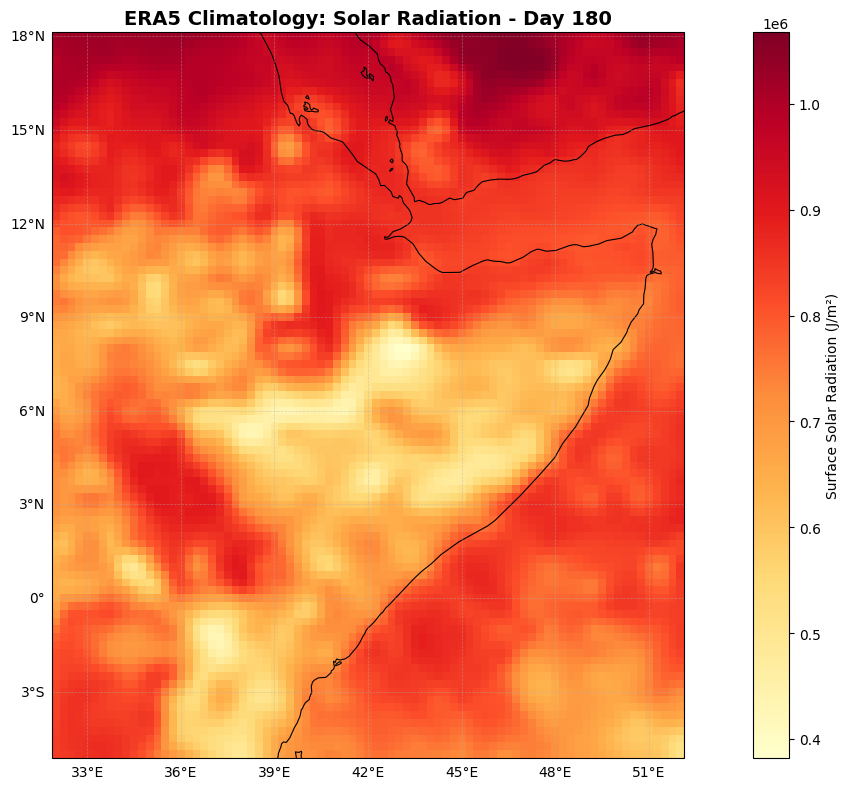

✓ Plotted climatology for day 180


In [12]:
# Visualize climatology for a specific day (e.g., day 180 ≈ June 29)
day_to_plot = 180

fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
climatology_ssrd['ssrd'].sel(dayofyear=day_to_plot).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='YlOrRd',
    cbar_kwargs={'label': 'Surface Solar Radiation (J/m²)'}
)

# Add map features
ax.coastlines(linewidth=0.8, color='black')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title(f'ERA5 Climatology: Solar Radiation - Day {day_to_plot}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✓ Plotted climatology for day {day_to_plot}")

## 5. Process All Variables

Now let's create a function to compute climatologies for all variables and save them.

In [13]:
def compute_climatology(dataset: xr.Dataset, var_name: str) -> xr.Dataset:
    """
    Compute day-of-year climatology for a given dataset.
    
    Args:
        dataset: xarray Dataset with valid_time dimension
        var_name: Name of the variable to process
        
    Returns:
        Dataset with climatology (averaged by day-of-year)
    """
    # Add day-of-year coordinate
    ds_with_doy = dataset.assign_coords(dayofyear=dataset.valid_time.dt.dayofyear)
    
    # Group by day-of-year and compute mean
    climatology = ds_with_doy.groupby('dayofyear').mean('valid_time')
    
    return climatology

# Test the function
clim_test = compute_climatology(ds_ssrd, 'ssrd')
print(f"✓ Function test successful")
print(f"  Input shape: {ds_ssrd['ssrd'].shape}")
print(f"  Output shape: {clim_test['ssrd'].shape}")

✓ Function test successful
  Input shape: (1394, 93, 81)
  Output shape: (366, 93, 81)


In [14]:
# Process all variables
climatology_output_dir = Path("data/climatology")
climatology_output_dir.mkdir(parents=True, exist_ok=True)

print("Processing all variables:")
print("=" * 60)

for var_name, filename in filename_dict.items():
    file_path = data_path / filename
    
    if not file_path.exists():
        print(f"⚠ Skipping {var_name}: file not found")
        continue
    
    print(f"\nProcessing: {var_name}")
    print("-" * 60)
    
    # Load dataset
    print(f"  Loading data from {filename}...")
    ds = xr.open_dataset(file_path)
    
    # Get the actual variable name from the dataset
    data_vars = list(ds.data_vars)
    if len(data_vars) == 1:
        actual_var = data_vars[0]
    else:
        # Try common variable names
        actual_var = data_vars[0]
    
    print(f"  Variable in dataset: {actual_var}")
    print(f"  Time range: {ds.valid_time.values[0]} to {ds.valid_time.values[-1]}")
    print(f"  Total timesteps: {len(ds.valid_time)}")
    
    # Compute climatology
    print(f"  Computing climatology...")
    climatology = compute_climatology(ds, actual_var)
    
    # Save climatology
    output_file = climatology_output_dir / f"{var_name}_climatology.nc"
    print(f"  Saving to {output_file}...")
    climatology.to_netcdf(output_file)
    
    print(f"  ✓ Complete - {len(climatology.dayofyear)} days")
    
    # Close datasets to free memory
    ds.close()

print("\n" + "=" * 60)
print(f"✓ All climatologies computed and saved to {climatology_output_dir}")
print(f"✓ Total files created: {len(list(climatology_output_dir.glob('*.nc')))}")

Processing all variables:

Processing: surface_solar_radiation_downwards
------------------------------------------------------------
  Loading data from surface_solar_radiation_downwards_stream-oper_daily-mean.nc...
  Variable in dataset: ssrd
  Time range: 2022-01-01T00:00:00.000000000 to 2025-10-25T00:00:00.000000000
  Total timesteps: 1394
  Computing climatology...
  Saving to data\climatology\surface_solar_radiation_downwards_climatology.nc...
  Saving to data\climatology\surface_solar_radiation_downwards_climatology.nc...


PermissionError: [Errno 13] Permission denied: 'c:\\projects\\Capacity-Building-ICPAC-for-climate-services\\Renewable_Energy_Forecasting\\data\\climatology\\surface_solar_radiation_downwards_climatology.nc'

## 6. Verify Saved Climatologies

Let's verify that all climatologies were saved correctly.

In [ ]:
# List all saved climatology files
climatology_files = sorted(climatology_output_dir.glob("*.nc"))

print(f"Saved climatology files ({len(climatology_files)}):")
print("=" * 60)

for file in climatology_files:
    # Open and check the file
    ds_check = xr.open_dataset(file)
    var_names = list(ds_check.data_vars)
    
    print(f"\n✓ {file.name}")
    print(f"  Variables: {var_names}")
    print(f"  Dimensions: {dict(ds_check.dims)}")
    print(f"  Day-of-year range: {int(ds_check.dayofyear.min())} - {int(ds_check.dayofyear.max())}")
    
    ds_check.close()

print("\n" + "=" * 60)
print("✓ All climatology files verified successfully!")

## 7. Analyze Time Series at a Specific Location

Let's extract and visualize the annual cycle of a variable at a specific location.

In [ ]:
# Select a location (e.g., Nairobi, Kenya: -1.28°N, 36.82°E)
location_name = "Nairobi, Kenya"
lat_point = -1.28
lon_point = 36.82

# Load the solar radiation climatology
clim_ssrd_reload = xr.open_dataset(climatology_output_dir / "surface_solar_radiation_downwards_climatology.nc")

# Extract time series at the location
location_series = clim_ssrd_reload['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

# Plot the annual cycle
fig, ax = plt.subplots(figsize=(14, 6))
location_series.plot(ax=ax, marker='o', markersize=3, linewidth=2, color='orangered')

ax.set_xlabel('Day of Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Surface Solar Radiation (J/m²)', fontsize=12, fontweight='bold')
ax.set_title(f'Annual Cycle of Solar Radiation - {location_name} ({lat_point}°N, {lon_point}°E)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add monthly markers
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(month_days)
ax.set_xticklabels(month_names)

plt.tight_layout()
plt.show()

print(f"✓ Annual cycle plotted for {location_name}")
print(f"  Nearest grid point: {float(location_series.latitude):.2f}°N, {float(location_series.longitude):.2f}°E")
print(f"  Mean value: {float(location_series.mean()):.2f} J/m²")
print(f"  Max value: {float(location_series.max()):.2f} J/m² (day {int(location_series.argmax())})")
print(f"  Min value: {float(location_series.min()):.2f} J/m² (day {int(location_series.argmin())})")

In [ ]:
# show climatology of the next 14 days

from datetime import datetime, timedelta
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
print(f"Today's date: {today.strftime('%Y-%m-%d')}")

# Select a location (e.g., Nairobi, Kenya: -1.28°N, 36.82°E)
location_name = "Nairobi, Kenya"
lat_point = -1.28
lon_point = 36.82

# Load the solar radiation climatology
clim_ssrd_reload = xr.open_dataset(climatology_output_dir / "surface_solar_radiation_downwards_climatology.nc")

# Extract time series at the location
location_series = clim_ssrd_reload['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
).sel(dayofyear=slice(today.timetuple().tm_yday, today.timetuple().tm_yday + 14))

# Plot the annual cycle
fig, ax = plt.subplots(figsize=(14, 6))
location_series.plot(ax=ax, marker='o', markersize=3, linewidth=2, color='orangered')

ax.set_xlabel('Day of Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Surface Solar Radiation (J/m²)', fontsize=12, fontweight='bold')
ax.set_title(f'Climatology of Solar Radiation - 14 days ahead - {location_name} ({lat_point}°N, {lon_point}°E)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Resources

- [ERA5 Documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation)